In [1]:
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
import gc
from concurrent.futures import ThreadPoolExecutor

In [2]:
def run_leiden(adata, resolution, key_added):
    adata_clustering = sc.tl.leiden(adata, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs

def run_leiden_parallel(adata_subset, tasks):
    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(run_leiden, adata_subset, resolution, key_added) for resolution, key_added in tasks]
        results = [future.result() for future in futures]

    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata_subset.obs[key_added] = result[key_added]

    return adata_subset

In [3]:
adata=sc.read_h5ad('adata_processed.h5ad')

In [4]:
NK_cell_population=['5','17']

In [5]:
adata_subset=adata[adata.obs['leiden'].isin(NK_cell_population)]

In [6]:
del adata 
gc.collect()

12

In [7]:
adata_subset=adata_subset.raw.to_adata()

In [8]:
adata_subset.write_h5ad('NK/NKcells_raw.h5ad')

In [9]:
adata_subset=sc.read_h5ad('NK/NKcells_raw.h5ad')

In [10]:
adata_subset.raw= adata_subset

In [11]:
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)


In [12]:
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]

In [13]:
sc.pp.scale(adata_subset)

In [14]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [15]:
sce.pp.harmony_integrate(adata_subset, 'cohort.cohortGuid',max_iter_harmony = 30)

2023-11-21 03:35:19,505 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2023-11-21 03:43:12,743 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2023-11-21 03:43:13,926 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2023-11-21 03:46:15,580 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2023-11-21 03:48:40,861 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2023-11-21 03:50:58,348 - harmonypy - INFO - Iteration 4 of 30
Iteration 4 of 30
2023-11-21 03:52:02,732 - harmonypy - INFO - Iteration 5 of 30
Iteration 5 of 30
2023-11-21 03:52:58,277 - harmonypy - INFO - Iteration 6 of 30
Iteration 6 of 30
2023-11-21 03:53:46,771 - harmonypy - INFO - Converged after 6 iterations
Converged after 6 iterations


In [16]:
sc.pp.neighbors(adata_subset, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata_subset,min_dist=0.05)

In [17]:
tasks = [(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
adata_subset = run_leiden_parallel(adata_subset, tasks)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [18]:
adata_subset.write_h5ad('NK/NKcells_processed.h5ad')

In [19]:
adata_subset=adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)
sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_1', method='wilcoxon')

df_resolution_1=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_1.to_csv('NK/NK_res1.csv')

sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_1.5', method='wilcoxon')
df_resolution_1_5=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_1_5.to_csv('NK/NK_res1.5.csv')

sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_2', method='wilcoxon')
df_resolution_2=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_2.to_csv('NK/NK_res2.csv')

/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [2]:
adata_subset=sc.read_h5ad('NK/NKcells_processed.h5ad')

In [3]:
sc.tl.umap(adata_subset,min_dist=0.05)

In [6]:
adata_subset.write_h5ad('NK/NKcells_processed_20231107.h5ad')

<Axes: title={'center': 'predicted.celltype.l3'}, xlabel='UMAP1', ylabel='UMAP2'>

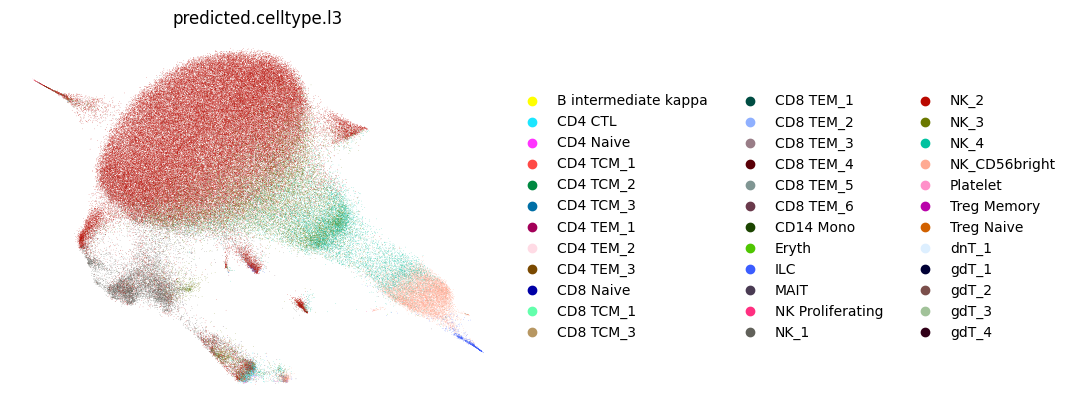

In [34]:
sc.pl.umap(adata_subset, color=['predicted.celltype.l3'], size=0.5,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'HBA1'}, xlabel='UMAP1', ylabel='UMAP2'>

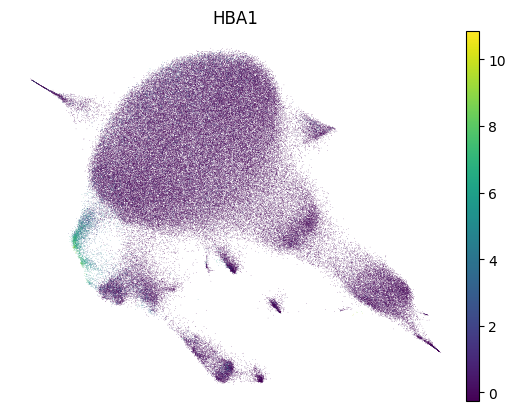

In [11]:
sc.pl.umap(adata_subset, color=['HBA1'], use_raw=False, size=0.5,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'predicted_labels_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

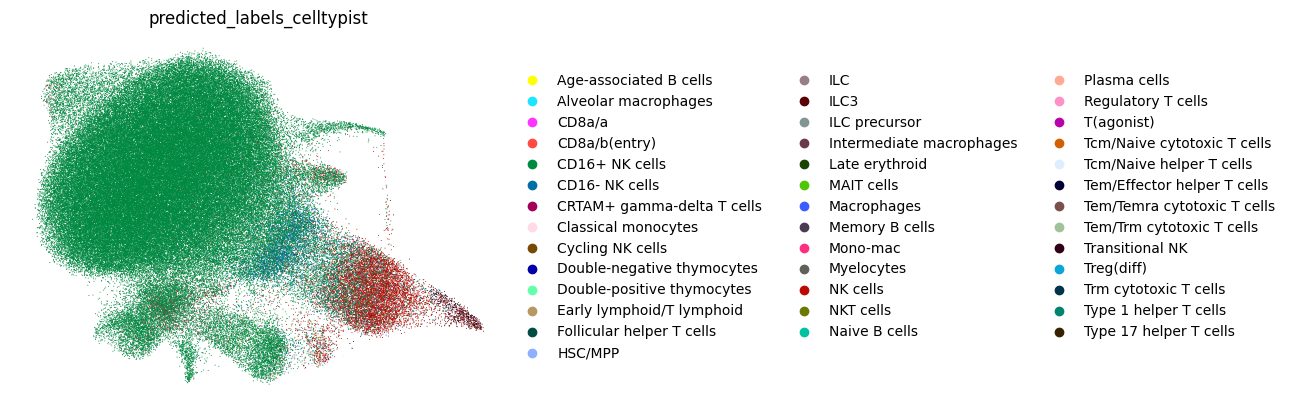

In [19]:
sc.pl.umap(adata_subset, color=['predicted_labels_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'majority_voting_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

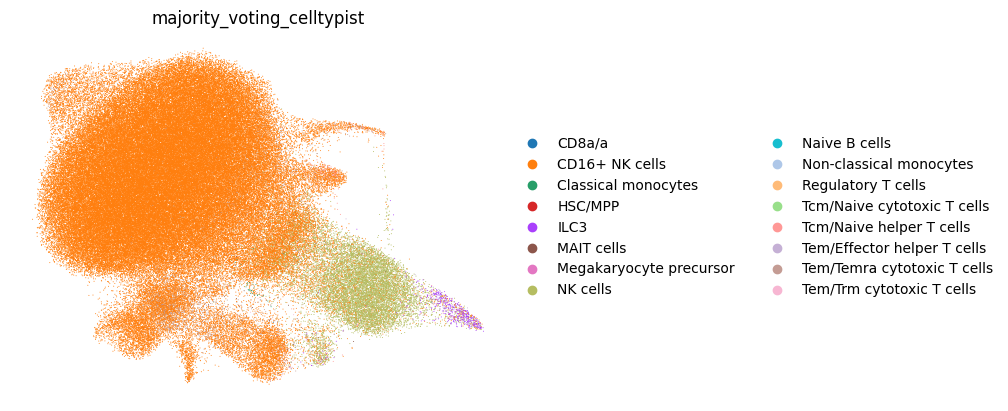

In [20]:
sc.pl.umap(adata_subset, color=['majority_voting_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

[<Axes: title={'center': 'leiden_resolution_1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden_resolution_1.5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden_resolution_2'}, xlabel='UMAP1', ylabel='UMAP2'>]

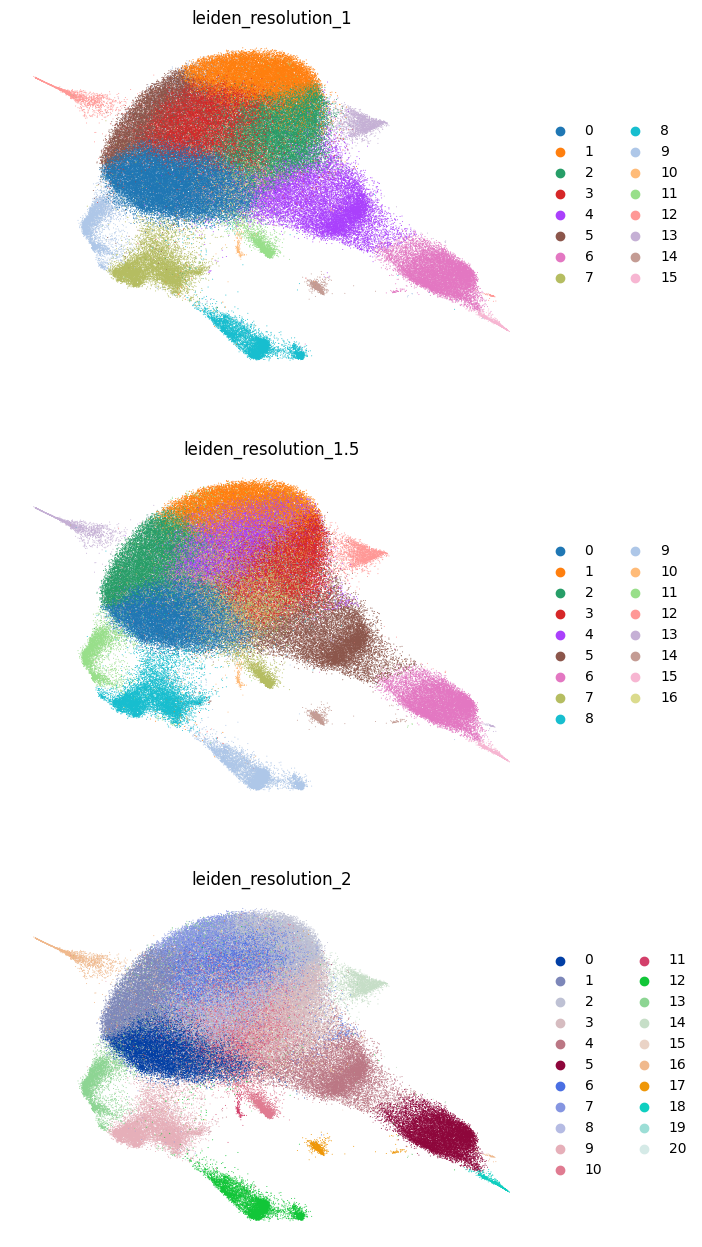

In [12]:
sc.pl.umap(adata_subset, color=['leiden_resolution_1','leiden_resolution_1.5','leiden_resolution_2'], 
           size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'leiden_resolution_1.5'}, xlabel='UMAP1', ylabel='UMAP2'>

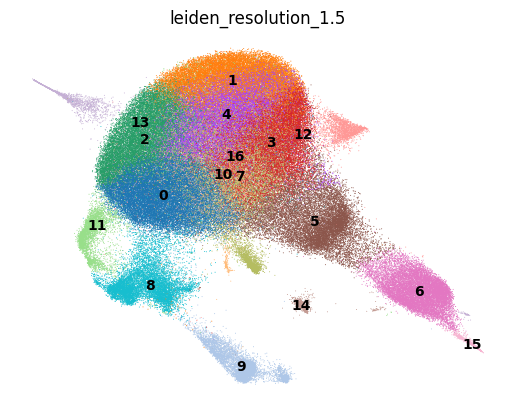

In [13]:
sc.pl.umap(adata_subset, color=['leiden_resolution_1.5'], legend_loc='on data',
           size=2,show=False,ncols=1 ,frameon=False)

[<Axes: title={'center': 'NCAM1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'FCGR3A'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'KLRC1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'KLRC2'}, xlabel='UMAP1', ylabel='UMAP2'>]

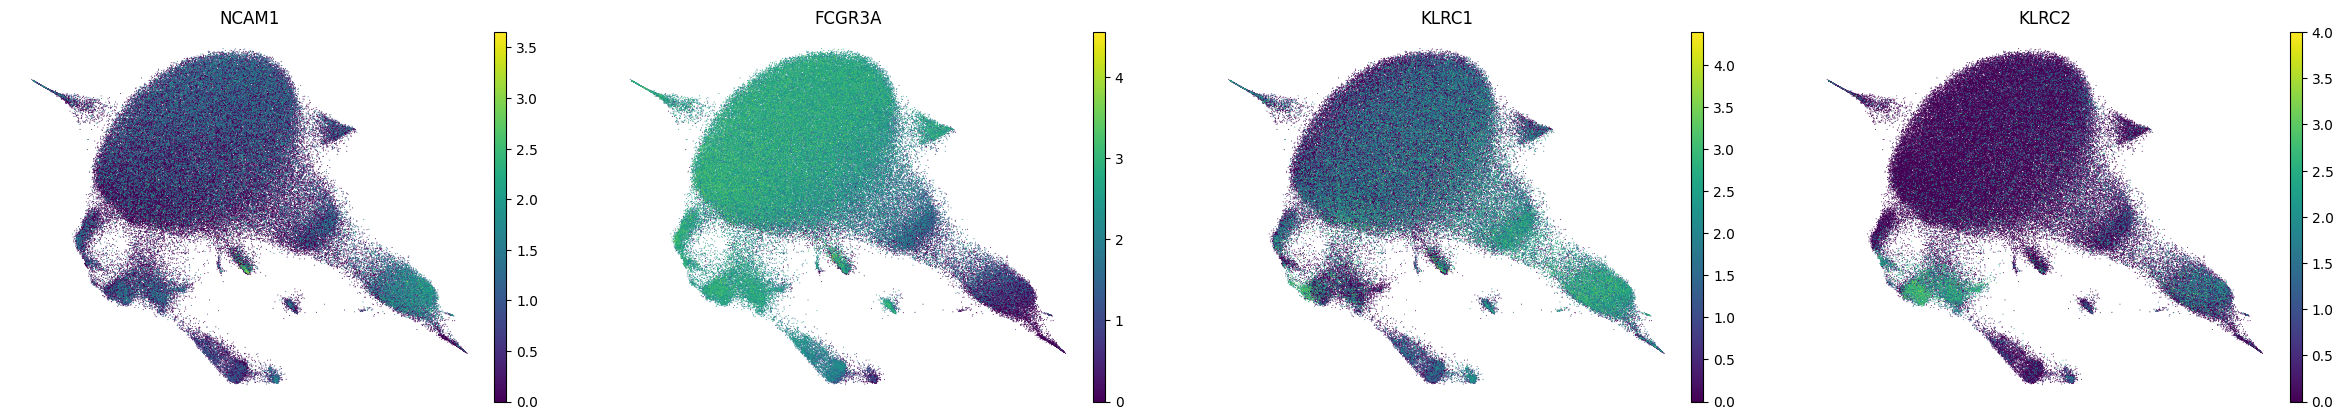

In [21]:
sc.pl.umap(adata_subset, color=['NCAM1','FCGR3A','KLRC1','KLRC2'], legend_loc='on data',
           size=2,show=False,ncols=4 ,frameon=False)

In [26]:
adata_subset

AnnData object with n_obs × n_vars = 159180 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top

[<Axes: title={'center': 'cohort.cohortGuid'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'CMV.IgG.Serology.Result.Interpretation'}, xlabel='UMAP1', ylabel='UMAP2'>]

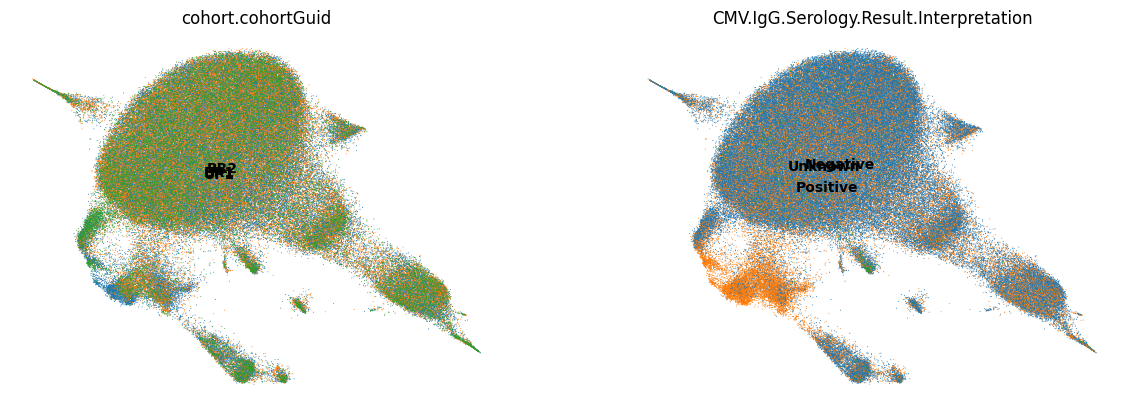

In [27]:
sc.pl.umap(adata_subset, color=['cohort.cohortGuid','CMV.IgG.Serology.Result.Interpretation'], legend_loc='on data',
           size=2,show=False,ncols=4 ,frameon=False)

In [38]:
adata_subset.obs.query("`leiden_resolution_1.5`=='16'")

barcodes batch_id  \
3987   a7175664489811ea92388a6a0c683ffb     B001   
17961  549c5b6c495311ea86cade558b2f8879     B001   
3049   1552fe3853f411eab4d5422f18e8d86e     B002   
14448  6617040453f411eab64ecef18f951453     B002   
8974   fe8a110853eb11ea8f1c0680d9aa37df     B002   
...                                 ...      ...   
18298  9a19241c50b411ec925dc6262e5ecc05     B096   
9512   1ebf5b0050b511ec8fafd2849fb52a10     B096   
8100   03879e4460a711edabbabeb8626370eb     B138   
15964  2d26d7d660b311edb0ce9a8d0a14da27     B138   
15870  03b22ff8608211ed8cb1a608efa7ae49     B138   

                          cell_name                         cell_uuid  \
3987           worse_balladic_indri  a7175664489811ea92388a6a0c683ffb   
17961      heartless_placid_karakul  549c5b6c495311ea86cade558b2f8879   
3049    halfcrazed_camouflage_midge  1552fe3853f411eab4d5422f18e8d86e   
14448  floodable_oceanic_coelacanth  6617040453f411eab64ecef18f951453   
8974    derelict_cactuslike_moorhen  fe8a110853eb11ea8f1c0680d9aa37df   
...                             ...                               ...   
18298             olive_silky_llama  9a19241c50b411ec925dc6262e5ecc05   
9512            stricken_rude_stilt  1ebf5b0050b511ec8fafd2849fb52a10   
8100                cloth_toxic_sow  03879e4460a711edabbabeb8626370eb   
15964     arcane_symbiotic_grayling  2d26d7d660b311edb0ce9a8d0a14da27   
15870  moderate_emulsible_kittiwake  03b22ff8608211ed8cb1a608efa7ae49   

         chip_id      hto_barcode hto_category  n_genes  n_mito_umis  n_reads  \
3987   B001-P1C1  TGATGGCCTATTGGG      singlet     1071           34     7252   
17961  B001-P1C2  TTCCGCCTCTCTTTG      singlet      799           51     4236   
3049   B002-P2C2  TGATGGCCTATTGGG      singlet     1424          118     8753   
14448  B002-P2C3  TGATGGCCTATTGGG      singlet     1515          120    10612   
8974   B002-P2C3  TGTCTTTCCTGCCAG      singlet     1697           95    11702   
...          ...              ...          ...      ...          ...      ...   
18298  B096-P2C3  GGTTGCCAGATGTCA      singlet     2024          182    16491   
9512   B096-P2C3  TGATGGCCTATTGGG      singlet     1049           53     6601   
8100   B138-P2C3  CTCCTCTGCAATTAC      singlet     1155           57     8432   
15964  B138-P2C3  CTCCTCTGCAATTAC      singlet     1459          140    11784   
15870  B138-P1C2  AAATCTCTCAGGCTC      singlet     1171           63     6082   

       ...  pct_counts_in_top_200_genes pct_counts_in_top_500_genes  \
3987   ...                    55.474784                   74.057247   
17961  ...                    49.916388                   75.000000   
3049   ...                    53.126002                   70.375120   
14448  ...                    56.764785                   72.589792   
8974   ...                    50.709779                   67.744479   
...    ...                          ...                         ...   
18298  ...                    50.703659                   66.003217   
9512   ...                    52.693438                   73.114594   
8100   ...                    54.116638                   71.912521   
15964  ...                    59.190283                   74.116059   
15870  ...                    56.154748                   73.778820   

      total_counts_mito log1p_total_counts_mito pct_counts_mito  leiden  \
3987                 34                3.555348        1.544752       3   
17961                51                3.951244        4.264214       3   
3049                118                4.779123        3.783264       3   
14448               120                4.795791        3.240616       3   
8974                 95                4.564348        2.497371       3   
...                 ...                     ...             ...     ...   
18298               182                5.209486        3.659027       3   
9512                 53                3.988984        2.595495       3   
8100                 57     

In [33]:
adata_subset.obs.query("`leiden_resolution_1.5`=='12'")['subject.subjectGuid'].value_counts(normalize=True).head(10)

subject.subjectGuid
BR1014    0.151453
BR1059    0.063579
BR1051    0.037239
UP1023    0.030881
BR2013    0.029973
BR1017    0.026794
UP1011    0.025204
BR2016    0.024523
BR2023    0.023842
BR1016    0.022707
Name: proportion, dtype: float64

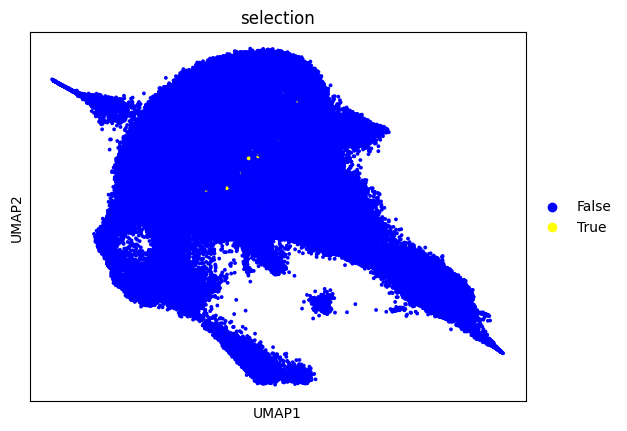

In [40]:
adata_subset.obs['selection'] =pd.Categorical( adata_subset.obs['leiden_resolution_1.5']=='16')
# adjust colors
adata_subset.uns['selection_colors'] = ['blue', 'yellow']
sc.pl.umap(adata_subset, color='selection',s=30)

<Axes: title={'center': 'CMV.IgG.Serology.Result.Interpretation'}, xlabel='UMAP1', ylabel='UMAP2'>

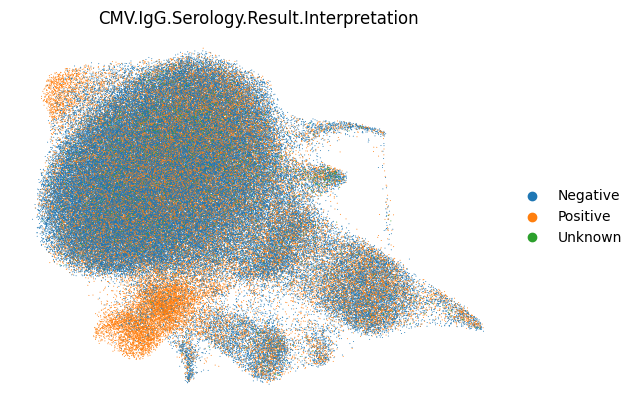

In [22]:
sc.pl.umap(adata_subset, color=['CMV.IgG.Serology.Result.Interpretation'], size=2,show=False,ncols=1 ,frameon=False)

In [41]:
df=pd.read_csv('NK/NK_res1.5.csv')


In [42]:
df=df.groupby('group').head(20).reset_index(drop=True)

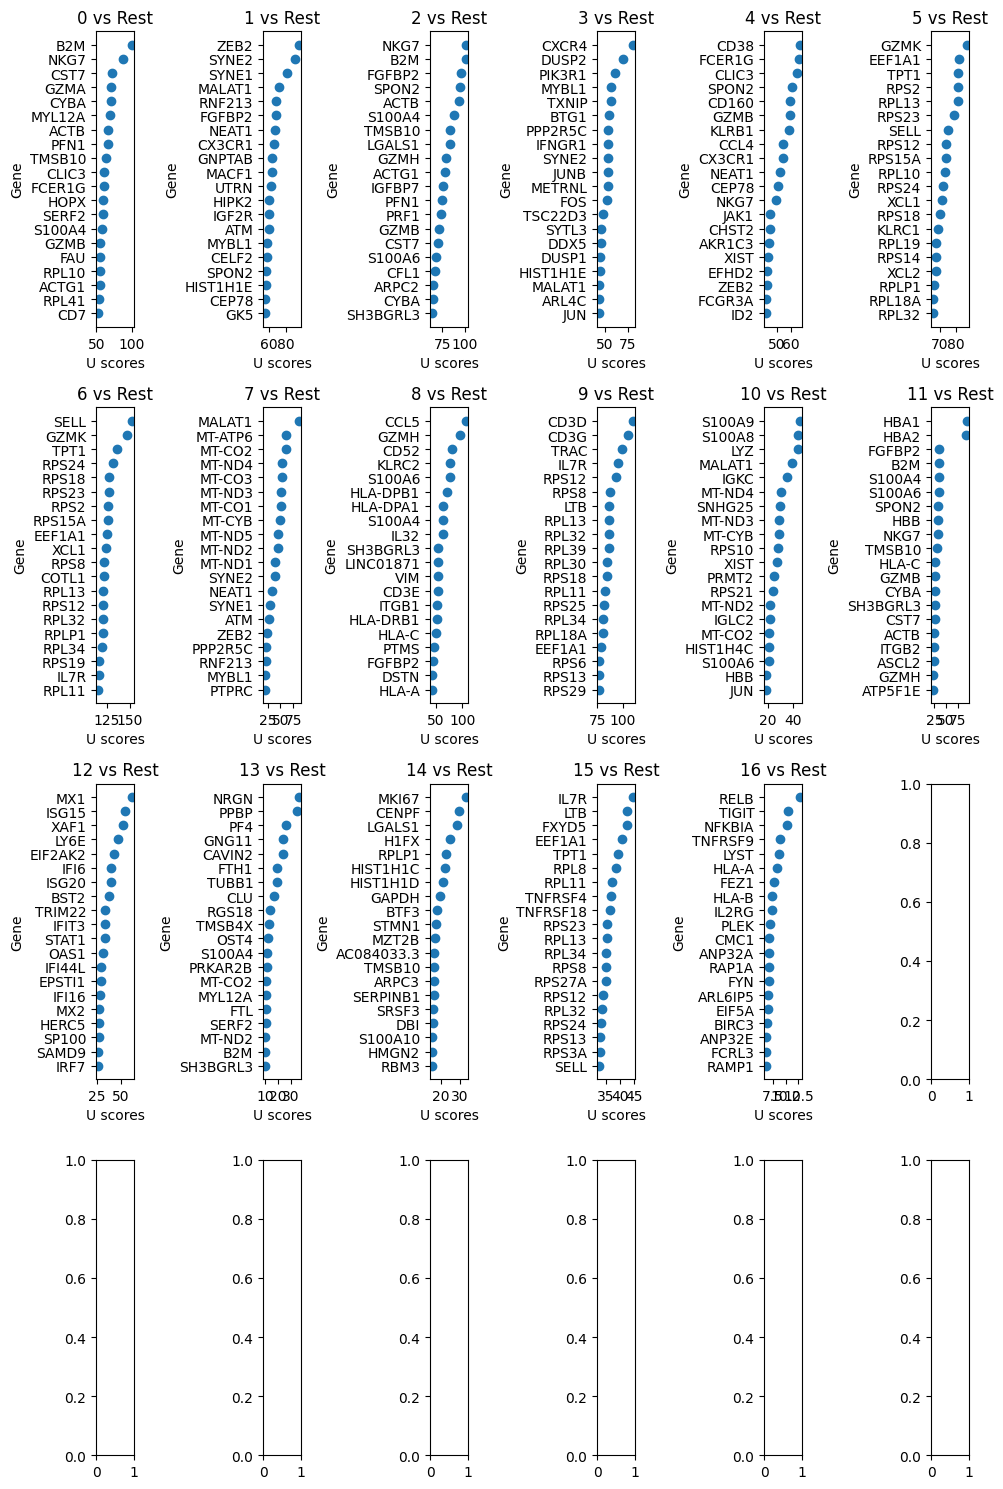

In [43]:
import matplotlib.pyplot as plt

groups = df.groupby('group')

fig, axs = plt.subplots(4, 6, figsize=(10, 15), squeeze=False)

# Loop through each group and create a scatter plot in the corresponding subplot
for i, (name, group) in enumerate(groups):
    row, col = i // 6, i % 6
    axs[row, col].scatter(group['scores'], group['names'])
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(str(name)+" vs Rest")
    axs[row, col].set_xlabel('U scores')
    axs[row, col].set_ylabel('Gene')
fig.tight_layout()
plt.savefig('scatter_plot.png')